# Tuning curves and place cells

<div class="alert alert-block alert-info">


### ABOUT THIS LESSON 
---

Lesson time: 60 m   
Contributors: Francesco Battaglia, Davide Spalla


**In this lesson you will learn:**
- How to visualize the response of single neurons with peri-stimulus time histograms (PSTH) and tuning curves
- How to use these techniquese to study space-selective cells (Place Cells) in the hippocampus
- How to quantify the selectivity of single cells



In [11]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm

## Introduction
---
 
General introduction

## Visualizing the response of a neuron
---
- Peri stimulus time histogram, for stimuli presentation with a fixed value
- Tungin curve, change in average response as a funtion of stimulus

## PSTH example: sound presentation 
---
Descibe data: simulation of a sound presentation for N trials

In [35]:
#import data

# cut and align to stimulus presentation

# plot event plot for different neurons, with ipy widgets

In [ ]:
# extra: Pynapple plotter?

## Tuning curve example: Place cells
---

Place cells are cells in the hippocampus that activate when the animal (typically rat or mouse) passes through a specific place in an environment. Together place cells for a spatial map of the environment that is supposed to support episodic memory. A good review on place cells is the one by [Moser et al](https://www.annualreviews.org/doi/full/10.1146/annurev.neuro.31.061307.090723?url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org&rfr_dat=cr_pub%3Dpubmed). Some more information on the hippocampus [here](http://www.scholarpedia.org/article/Hippocampus#Hippocampal_place_cells_and_episode_cells)

In a typical place cell experiment, multiple hippocampal neurons are recorded at the same time eg. with a multi-tetrode array. For each cell (as a result of the spike sorting process, that we will not cover here) we get the time series of the times of the spikes that each cell emitted. In addition we will get information about the position of the animal at any point in time. Typically, this is obtained by filming the animal movement with a video-camera, and use a video-tracking algorithm to find the animal position in each frame. Thus, we will get a time series with the times of each frame and the position of the animal (X and Y coordinates, or in the case of running on a linear track, only a 1-D coordinate. To find the animal position at the moment of the emission of each spike (which is the basic unit of information for our analysis) we will therefore have to "synchronize and realign" these different types of time series. 

### Simulating place cell activity

To get started, we will create and analyze some simulated data, where we will have more control. We will first generate "ground truth" firing rate maps, and then simulate spike trains as inhomogeneous Poisson processes, with a rate determined by the current animal position. 
An inhomogeneous Poisson process is a random process where the instantaneous probability to have an event at time $t$ (more precisely, the probability of having an event between times $t$ and $t + dt$ is given by:

$$p(event in [t, t+dt]) = \lambda(t)dt$$

Here we define the parameters for the simulation. We will consider a 1-D environment, such as linear track

In [3]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

The probaility distribution for the place field size has shape

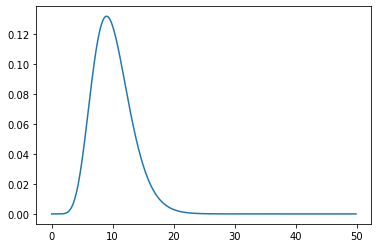

In [4]:
x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)
plt.plot(x, g)

In [5]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

Text(0, 0.5, 'cell #')

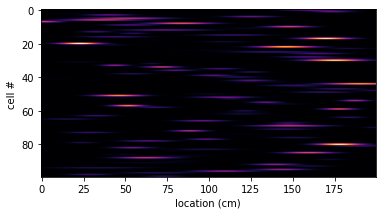

In [6]:
plt.imshow(true_firing_rate_maps, cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')

Now plotting them in the order of place field (common plot type in the field)

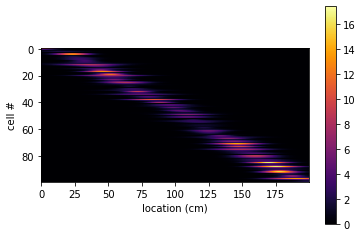

In [7]:
ix = np.argsort(pf_centers)
plt.imshow(true_firing_rate_maps[ix,:], cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

Now let's simulate the "mouse" trajectory. The mouse will shuttle back and forth on the linear track and will stop at the two ends to eat. We will make a very rough simulation, in which the running speed will be constant for each run

In [8]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

t` and `x` are, respectively, the times, and position readouts for all the video frames. This pair represent the first time series that we will encounter in a typical experiment. 

This is what the mouse trajectory looks like

Text(0, 0.5, 'position on track (cm)')

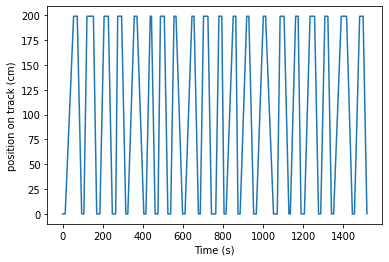

In [9]:
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)')

The cell below draws spikes according to an inhomogeneous Poisson process. This is the heart of the simulation. Look at the `for` loop, what is each line of code doing?

In [12]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

100%|██████████| 100/100 [00:34<00:00,  2.90it/s]


<div class="alert alert-block alert-success"> 

### Displaying loop progress with TQDM

Tip cell on tqdm and other progress bars

## Analysis of place-related spiking activity

spikes` and the pair `t, x` contain the information that we typically get from an experiment. Thus, our analyses will focus on those. 

In the lines below, we plot the positions at which the spikes are fired. 

Note two important things

- the use of `np.interp` (check the documentation!) to realign the spikes and the position time series. That instruction returns a series of the positions at which spikes were fired. This is a key operation that you will perform many times in the context of these analyses 

- the use of `interact` (from `ipywidgets`) to make an interactive plot so that we quickly explore the behavior of all cells


In [15]:
def plot_unit(i):
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

In [14]:
spike_positions = [np.interp(s, t, x) for s in spikes]

<div class="alert alert-block alert-success"> 

### List comprehension

 a typical Python construct, a _list comprehension_ (check the docs if you don't know what that is! Spoiler: it's a handy way to replace a for loop)

Now let's make experimental firing rate maps, by taking the histogram of the spikes at each position and normalizing it by the "occupancy" that is, the time at each point on the track.

In [16]:
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

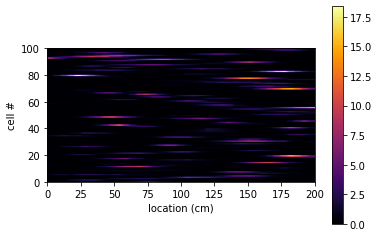

In [17]:
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

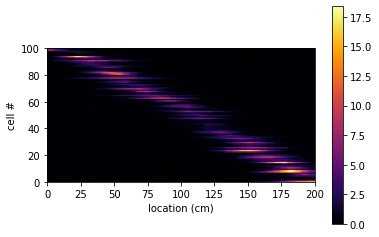

In [18]:
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

Conclusion remarks on place cells and tuning curves

## Mutual information 

What makes a place cell? We are looking for cells with some amount of spatial selectivity. But how to we define/quantify that precisely?
One way is to use information theory. In particular mutual information is a way to quantify the degree of association between two random variables, such as the firing of an hippocampal cell and the position of a mouse. [Skaggs et al.](https://papers.nips.cc/paper/671-an-information-theoretic-approach-to-deciphering-the-hippocampal-code.pdf) defined a widely used formula to compute this "spatial information"  for the case of place cells. 

$$ I = \sum_x \lambda(x) \log_2 \frac{\lambda(x) + \epsilon}{\lambda} p_{occ}(x) $$ 

Where $\epsilon$ is a very small number (e.g. $10^{-15}$) This small number avoids infinities (and NaNs) when $\lambda(x) = 0$.

where $\lambda(x)$ is the firing rate map (as defined above, with some binning precision) $\lambda$ is the average firing rate of the neuron, and $p_{occ}(x)$ is the occupancy as defined above. Information from this formula is expressed in bits per second. An alternative definition is expressed in bits/spike:

$$ I_s = \frac{I}{\lambda}$$ 

(same formula as above divided by average firing rate). This second definition favors low-firing rate cells (typical for place cells)

## Working with real data

## 1D environment

In [ ]:
# show how to get the data

# descibre data

# leave as exercise

## 2D environment

In [ ]:
# show how to get the data

# descibre data

# show 2d tuning curves

<div class="alert alert-block alert-info">


### Key points 

- PSTH and tuning curves are useful tools to visualize stimulus-related nerual activity.  
- Place cells are cell whose firing rate is modulated by the animal's position in an environment.  
- The selectivity of place cells can be visualized with their firing rate maps (space related tuning curves), and quantified with information metrics such as the Mutual Information

<div class="alert alert-block alert-info">


### References and resources

**Books & papers**
* Chapter on tuning curves in dayan and Abbot
* Add reference on PSTH
* Reviews on place cells
* Review on mutual information


**Software**
* Pynapple library



## Exercises
You can find the exercises for this lessons in [notebook name](notebook_link)